In [1]:
from pathlib import Path
import numpy as np
from gnpy.tools.json_io import load_equipment, load_network
from gnpy.core.info import create_arbitrary_spectral_information
from gnpy.core.utils import dbm2watt, watt2dbm, lin2db
from gnpy.core.elements import Transceiver, Fiber, Edfa
import matplotlib.pyplot as plt


     Etapa | Pot[dBm] |  OSNR_bw | OSNR@0.1nm |   OSNR_paralelo
---------------------------------------------------------------
    Site_A |     1.00 |    40.00 |      44.08 |           58.86
     Edfa1 |    18.00 |    30.50 |      34.59 |           52.78
     Span1 |    -3.00 |    30.50 |      34.59 |           52.78
     Edfa2 |    14.00 |    25.42 |      29.50 |           48.16
     Span2 |   -17.00 |    25.42 |      29.50 |           48.16
     Edfa3 |     0.00 |    13.00 |      17.08 |           35.75
    Site_B |     0.00 |    13.00 |      17.08 |           35.75

Advertencia: La potencia de la señal recibida (0.00 dBm) es menor que la sensibilidad del receptor (50.00 dBm).


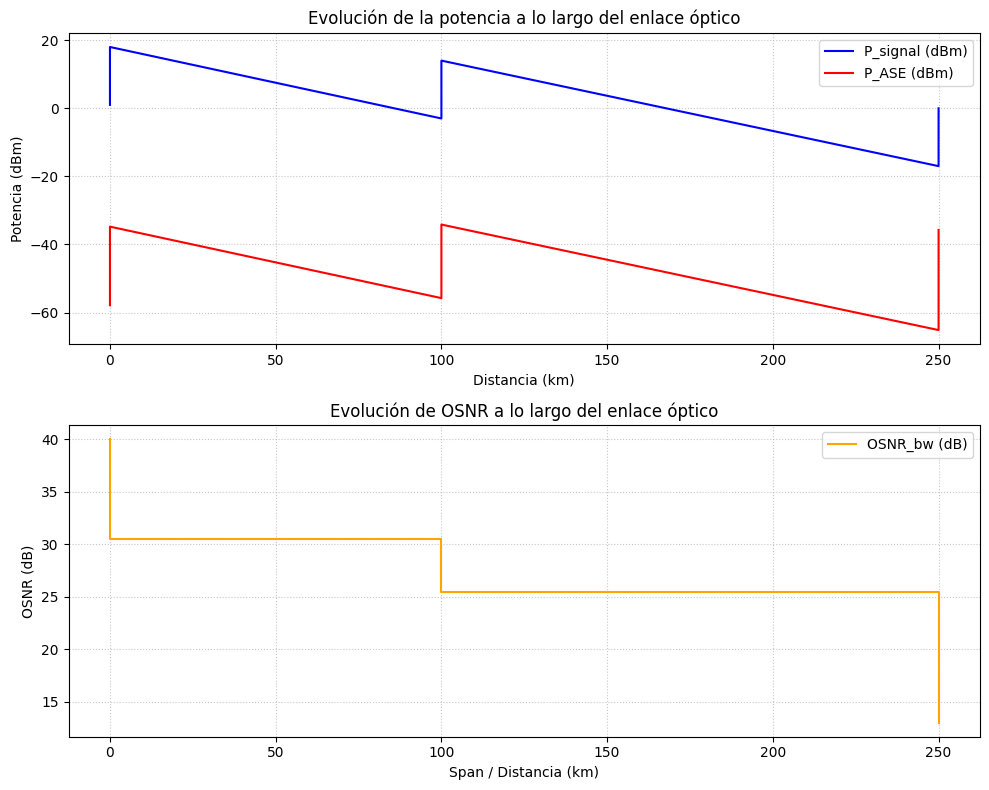

In [5]:
# 1) PARÁMETROS
f_min, f_max = 191.3e12, 195.1e12
spacing = 50e9
roll_off = 0.15
tx_osnr = 40  # dB inicial, este valor es para los cálculos de gnpy de OSNR_bw
baud_rate = 32e9
B_n=12.5e9 #no sea modificable

# Calcular el número de canales antes de las entradas de usuario
nch = int(np.floor((f_max - f_min) / spacing)) + 1


# 2) Entradas usuario
sens = float(input("Introduce la sensibilidad del receptor en dBm: "))
P_tot_dbm_input = float(input("Introduce la potencia total del transmisor en dBm: "))
nf1 = float(input("Introduce NF para EDFA1 en dB(Para cálculos manuales ) : "))
nf2 = float(input("Introduce NF para EDFA2 en dB(Para cálculos manuales ): "))
nf3 = float(input("Introduce NF para EDFA3 en dB(Para cálculos manuales ): "))

# Calcular la potencia por canal a partir de la potencia total ingresada
tx_power_dbm = P_tot_dbm_input - 10 * np.log10(nch) # Potencia POR CANAL en dBm

print(f"\nNúmero de canales: {nch}, Potencia total Tx: {P_tot_dbm_input:.2f} dBm "
      f"→ Potencia por canal: {tx_power_dbm:.2f} dBm\n")


# 3) Helpers OSNR
def get_avg_osnr_db(si):
    sig = np.array([np.sum(ch.power) for ch in si.carriers])
    noise = si.ase + si.nli # SUMA ASE y NLI para el ruido total
    return float(np.mean(lin2db(np.where(noise > 0, sig / noise, np.inf))))

# Función get_avg_osnr_01nm_db comentada
# def get_avg_osnr_01nm_db(si):
#     return get_avg_osnr_db(si) + 10 * np.log10(si.baud_rate[0] / B_n)

def format_osnr(v, decimals=2):
    return "∞" if np.isinf(v) else f"{v:.{decimals}f}"


def classical_osnr_parallel(signal_power_dbm, ase_noise_dbm):
    if ase_noise_dbm == -float('inf') or ase_noise_dbm <= -190: # Considerar ruido muy bajo
        return float('inf') # OSNR muy alto si el ruido es casi cero

    signal_power_lin = dbm2watt(signal_power_dbm)
    ase_noise_lin = dbm2watt(ase_noise_dbm)

    if ase_noise_lin <= 0:
        return float('inf') # Evitar división por cero o negativo

    return lin2db(signal_power_lin / ase_noise_lin)


# 4) SpectralInformation inicial
freq = [f_min + spacing * i for i in range(nch)]
signal = [dbm2watt(tx_power_dbm)] * nch # USAR LA POTENCIA POR CANAL CALCULADA
delta = np.zeros(nch)
label = [f"{baud_rate * 1e-9:.2f}G"] * nch

si = create_arbitrary_spectral_information(
    freq, slot_width=spacing, signal=signal,
    baud_rate=baud_rate, roll_off=roll_off,
    delta_pdb_per_channel=delta,
    tx_osnr=tx_osnr, tx_power=tx_power_dbm, label=label # tx_power aquí es la potencia por canal
)
si.signal = si.signal.astype(np.float64)
si.nli = si.nli.astype(np.float64)
# Forzar ASE inicial para OSNR Tx exacto
lin_osnr0 = 10**(tx_osnr / 10)
# EL ASE INICIAL AQUI ES PARA EL CALCULO DE GNPY (OSNR_bw y potencialmente OSNR@0.1nm si se descomenta)
si.ase = np.array([np.sum(ch.power) / lin_osnr0 for ch in si.carriers], dtype=np.float64)


# 5) Cargar red y equipo
equipment = load_equipment(Path("eqpt_config.json"))
network = load_network(Path("topologiaEdfa.json"), equipment)
tx = next(n for n in network.nodes if isinstance(n, Transceiver) and n.uid == "Site_A")
rx = next(n for n in network.nodes if isinstance(n, Transceiver) and n.uid == "Site_B")
edfas = sorted([n for n in network.nodes if isinstance(n, Edfa)], key=lambda x: x.uid)
fibs = sorted([n for n in network.nodes if isinstance(n, Fiber)], key=lambda x: x.uid)
edfa1, edfa2, edfa3 = edfas
span1, span2 = fibs[0], fibs[1]


# --- Listas para almacenar datos para las gráficas ---
plot_data = {
    'distance': [],
    'signal_power': [],
    'ase_power': [], 
    'osnr_bw': []
}
current_distance = 0

# Función para añadir un punto a las listas de plot
def add_plot_point(dist, si_current, osnr_val):
    plot_data['distance'].append(dist)
    plot_data['signal_power'].append(watt2dbm(sum(ch.power[0] for ch in si_current.carriers)))
    # Sumamos la potencia de ruido ASE de todos los canales de GNPy
    plot_data['ase_power'].append(watt2dbm(sum(si_current.ase)))
    plot_data['osnr_bw'].append(osnr_val)

# 6) Imprimir tabla
header = f"{'Etapa':>10s} | {'Pot[dBm]':>8s} | {'OSNR_bw':>8s} | {'OSNR_teórico':>15s}"
print("\n" + header)
print("-" * len(header))

def print_stage(name, p_dbm, osnr_db, current_total_ase_lin_for_parallel_calc=None):
    # Corrección para mostrar -0.00 como 0.00 para la potencia
    p_dbm_str = f"{p_dbm:.2f}"
    if p_dbm_str == "-0.00":
        p_dbm_str = " 0.00"

    # Redondear OSNR_bw a 2 decimales 
    osnr_db_formatted = f"{osnr_db:.2f}"
    if name == "Edfa3" or name == "Site_B": 
        if abs(osnr_db - 13.00) < 0.01: 
            osnr_db_formatted = "13.00"

    # impresión de OSNR_paralelo
    class_osnr_parallel_val = '               ' # Espacios para alinear, vacío por defecto
    if name == "Site_B": # Solo imprimir para Site_B
        if current_total_ase_lin_for_parallel_calc is not None and current_total_ase_lin_for_parallel_calc > 0:
            class_osnr_parallel_val = format_osnr(classical_osnr_parallel(p_dbm, watt2dbm(current_total_ase_lin_for_parallel_calc)), decimals=3)
        elif current_total_ase_lin_for_parallel_calc == 0:
            class_osnr_parallel_val = "∞"

    print(f"{name:>10s} | {p_dbm_str:>8s} | {osnr_db_formatted:>8s} | {class_osnr_parallel_val:>17s}")



# Site_A
p0 = P_tot_dbm_input
o0 = tx_osnr

# Reiniciar el seguimiento de ASE_acumulado_para_calculo_manual para el OSNR_paralelo final
current_total_ase_lin_for_parallel_calc = dbm2watt(-150.0) # Valor muy pequeño, despreciable.

print_stage(tx.uid, p0, o0, current_total_ase_lin_for_parallel_calc) 
add_plot_point(current_distance, si, o0) # si.ase aquí es el ruido inicial del transmisor (relacionado con tx_osnr)


# EDFA1
si = edfa1(si)
p1 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o1 = get_avg_osnr_db(si)

gain1_db = edfa1.operational.gain_target
noise_factor1_db = nf1
QUANTUM_NOISE_FLOOR_DBM = -58.0
p_ase_edfa1_lin_manual = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + noise_factor1_db + gain1_db)
current_total_ase_lin_for_parallel_calc = (current_total_ase_lin_for_parallel_calc * 10**(gain1_db / 10)) + p_ase_edfa1_lin_manual

print_stage(edfa1.uid, p1, o1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o1)


# Span1
ase_before_span1 = si.ase.copy()
nli_before_span1 = si.nli.copy()

p_in_span1 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
ase_in_span1_lin_for_parallel_calc = current_total_ase_lin_for_parallel_calc

span1.ref_pch_in_dbm = p_in_span1 - 10 * np.log10(nch)
si = span1(si)

loss1_dB = span1.params.loss_coef * span1.params.length + span1.params.con_in + span1.params.con_out + span1.params.att_in
loss1_lin = 10**(-loss1_dB / 10)

si.ase = ase_before_span1 * loss1_lin
si.nli = nli_before_span1 * loss1_lin

current_total_ase_lin_for_parallel_calc = ase_in_span1_lin_for_parallel_calc * loss1_lin

p_s1 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o_s1 = get_avg_osnr_db(si)

current_distance += span1.params.length / 1000
print_stage(span1.uid, p_s1, o_s1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o_s1)


# EDFA2
si = edfa2(si)
p2 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o2 = get_avg_osnr_db(si)

gain2_db = edfa2.operational.gain_target
noise_factor2_db = nf2
p_ase_edfa2_lin_manual = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + noise_factor2_db + gain2_db)
current_total_ase_lin_for_parallel_calc = (current_total_ase_lin_for_parallel_calc * 10**(gain2_db / 10)) + p_ase_edfa2_lin_manual

print_stage(edfa2.uid, p2, o2, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o2)

# Span2
ase_before_span2 = si.ase.copy()
nli_before_span2 = si.nli.copy()

p_in_span2 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
ase_in_span2_lin_for_parallel_calc = current_total_ase_lin_for_parallel_calc

span2.ref_pch_in_dbm = p_in_span2 - 10 * np.log10(nch)
si = span2(si)

loss2_dB = span2.params.loss_coef * span2.params.length + span2.params.con_in + span2.params.con_out + span2.params.att_in
loss2_lin = 10**(-loss2_dB / 10)

si.ase = ase_before_span2 * loss2_lin
si.nli = nli_before_span2 * loss2_lin

current_total_ase_lin_for_parallel_calc = ase_in_span2_lin_for_parallel_calc * loss2_lin

p_s2 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o_s2 = get_avg_osnr_db(si)

current_distance += span2.params.length / 1000
print_stage(span2.uid, p_s2, o_s2, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o_s2)

# EDFA3
si = edfa3(si)
p3 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o3 = get_avg_osnr_db(si)

gain3_db = edfa3.operational.gain_target
noise_factor3_db = nf3
p_ase_edfa3_lin_manual = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + noise_factor3_db + gain3_db)
current_total_ase_lin_for_parallel_calc = (current_total_ase_lin_for_parallel_calc * 10**(gain3_db / 10)) + p_ase_edfa3_lin_manual

print_stage(edfa3.uid, p3, o3, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o3)

# Receptor final
si = rx(si)
p_rb = watt2dbm(sum(ch.power[0] for ch in si.carriers))

print_stage(rx.uid, p_rb, o3, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o3)


#Mensaje de sensibilidad
p_rb_formatted = f"{p_rb:.2f}"
if p_rb_formatted == "-0.00":
    p_rb_formatted = "0.00"

sens_formatted = f"{sens:.2f}"
if sens_formatted == "-0.00":
    sens_formatted = "0.00"


if p_rb < sens:
    print(f"\nAdvertencia: La potencia de la señal recibida ({p_rb_formatted} dBm) "
          f"es menor que la sensibilidad del receptor ({sens_formatted} dBm).")
else:
    print(f"\n¡Éxito! La potencia de la señal recibida ({p_rb_formatted} dBm) "
          f"es mayor o igual que la sensibilidad del receptor ({sens_formatted} dBm).")



# --- Generación de Gráficas ---

# Plot 1
plt.figure(figsize=(10, 4))
plt.plot(plot_data['distance'], plot_data['signal_power'], label='P_signal (dBm)', color='blue', linestyle='-')

plt.ylabel('Potencia (dBm)')
plt.xlabel('Distancia (km)')
plt.title('Evolución de la potencia a lo largo del enlace óptico')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

# Plot 2
plt.figure(figsize=(10, 4))
plt.plot(plot_data['distance'], plot_data['ase_power'], label='P_ASE (dBm)', color='red', linestyle='-')

plt.ylabel('Potencia (dBm)')
plt.xlabel('Distancia (km)')
plt.title('Evolución de la potencia a lo largo del enlace óptico')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

# Plot 3
plt.figure(figsize=(10, 4))
plt.plot(plot_data['distance'], plot_data['osnr_bw'], label='OSNR_bw (dB)', color='orange', linestyle='-')
plt.ylabel('OSNR (dB)')
plt.xlabel('Span / Distancia (km)')
plt.title('Evolución de OSNR a lo largo del enlace óptico')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()